# EDA for Time Series Modeling with SARIMAX-LIGHTGBM-DeepAR

# Introduction

 In this notebook series, we’ll explore how different forecasting models can be applied to the same dataset and compare their strengths and weaknesses. To keep things consistent, both notebooks use the Beijing Multi-Site Air-Quality Data Set, which includes hourly air pollutant data collected from 12 monitoring sites between March 1st, 2013 and February 28th, 2017. We’ll focus on three models—SARIMAX, LightGBM, and DeepAR—to predict air pollution levels and see how their results differ when applied to the same real-world case.

**The Beijing Multi-Site Air Quality** dataset (often found on platforms like Kaggle or UCI Machine Learning Repository) typically includes hourly data for:

**Air Pollutants:** PM2.5, PM10, SO2, NO2, CO, O3.

**Meteorological Variables:** Temperature (TEMP), Pressure (PRES), Dew Point (DEWP), Rainfall (RAIN), Wind Speed (WSPM), Wind Direction (WDIR).

- **PM2.5 (Particulate Matter 2.5 micrometers or less in diameter):** These are fine inhalable particles with a diameter of 2.5 micrometers or less. They are often produced from combustion processes (like vehicle exhaust and power plants) and can also be formed in the atmosphere. Due to their small size, they can travel deep into the lungs and even enter the bloodstream, causing significant health issues.

- **PM10 (Particulate Matter 10 micrometers or less in diameter):** These are inhalable particles with a diameter of 10 micrometers or less. They include dust, pollen, and mold spores. These particles can get into the lungs and cause health problems.

- **SO2 (Sulfur Dioxide):** Sulfur dioxide is a gas produced by burning fossil fuels that contain sulfur, such as coal and oil. It is a major contributor to acid rain and can cause respiratory problems.

- **NO2 (Nitrogen Dioxide):** Nitrogen dioxide is a gas that is primarily produced from the burning of fossil fuels (like in vehicles and power plants). It contributes to the formation of smog and acid rain and can cause respiratory issues.

- **CO (Carbon Monoxide):** Carbon monoxide is a colorless, odorless gas produced by incomplete combustion of carbon-containing fuels (such as gasoline, coal, wood, and natural gas). It is particularly dangerous because it binds to hemoglobin in the blood more effectively than oxygen, reducing the blood’s ability to carry oxygen to vital organs and tissues.


- **O3 (Ozone):** Ozone is a gas that occurs naturally in the upper atmosphere, where it protects us from the sun's ultraviolet rays. However, at ground level, it is a harmful air pollutant that can cause respiratory problems.

- **TEMP** isTemperature

- **PRES** almost certainly stands for Atmospheric Pressure (also known as Barometric Pressure).

- **DEWP** refers to Dew Point. Dew point is the temperature at which air must be cooled to become saturated with water vapor. While it's a meteorological variable often included in air quality datasets as it influences atmospheric conditions and pollutant dispersion.

- **wd (Wind Direction)** The values in this column would typically be categorical ('E', 'ENE', 'NNE', 'N', 'NNW', 'NW', 'NE', 'SW', 'SSW', 'WSW',
'ESE', 'SE', 'S', 'WNW', 'SSE', 'W')

- **WSPM** refers to Wind Speed (in meters per second, or some other unit).

# Preparation

In [1]:
#!pip install --upgrade kagglehub

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.set_option('display.max_columns', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sid321axn/beijing-multisite-airquality-data-set")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'beijing-multisite-airquality-data-set' dataset.
Path to dataset files: /kaggle/input/beijing-multisite-airquality-data-set


In [5]:
csv_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

print(f"Found {len(csv_files)} CSV files:")
for f in csv_files:
    print(f)

Found 12 CSV files:
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Guanyuan_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Aotizhongxin_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Wanliu_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Tiantan_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Wanshouxigong_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Nongzhanguan_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Shunyi_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Changping_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Dingling_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Huairou_20130301-20170228.csv
/kaggle/input/beijing-multisite-airquality

In [7]:
dataset = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
        station_name = os.path.basename(file).split('_')[2]
        df['station'] = station_name

        cols = list(df.columns)

        dataset.append(df)
        print(f"Successfully loaded {file} with {len(df)} rows. Added station: {station_name}")
    except Exception as e:
        print(f"Error reading {file}: {e}")

Successfully loaded /kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Guanyuan_20130301-20170228.csv with 35064 rows. Added station: Guanyuan
Successfully loaded /kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Aotizhongxin_20130301-20170228.csv with 35064 rows. Added station: Aotizhongxin
Successfully loaded /kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Wanliu_20130301-20170228.csv with 35064 rows. Added station: Wanliu
Successfully loaded /kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Tiantan_20130301-20170228.csv with 35064 rows. Added station: Tiantan
Successfully loaded /kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Wanshouxigong_20130301-20170228.csv with 35064 rows. Added station: Wanshouxigong
Successfully loaded /kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Nongzhanguan_20130301-20170228.csv with 35064 rows. Added station: Nongzhanguan
Successfully loaded /kaggle/input/beijing-multisite-airq

In [8]:
df = pd.concat(dataset, ignore_index=False)

display(df.head())
display(df.tail())

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Guanyuan
1,2,2013,3,1,1,4.0,4.0,13.0,17.0,300.0,72.0,-1.1,1023.2,-18.2,0.0,N,4.7,Guanyuan
2,3,2013,3,1,2,3.0,3.0,10.0,19.0,300.0,69.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Guanyuan
3,4,2013,3,1,3,3.0,6.0,7.0,24.0,400.0,62.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Guanyuan
4,5,2013,3,1,4,3.0,6.0,5.0,14.0,400.0,71.0,-2.0,1025.2,-19.5,0.0,N,2.0,Guanyuan


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
35059,35060,2017,2,28,19,16.0,51.0,3.0,29.0,400.0,73.0,12.5,1013.5,-16.2,0.0,NW,2.4,Dongsi
35060,35061,2017,2,28,20,18.0,45.0,3.0,43.0,500.0,54.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Dongsi
35061,35062,2017,2,28,21,23.0,58.0,5.0,61.0,700.0,28.0,10.8,1014.2,-13.3,0.0,NW,1.1,Dongsi
35062,35063,2017,2,28,22,23.0,53.0,9.0,75.0,900.0,15.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Dongsi
35063,35064,2017,2,28,23,30.0,71.0,11.0,87.0,1200.0,4.0,8.6,1014.1,-15.9,0.0,NNE,1.3,Dongsi


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420768 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 61.0+ MB


In [10]:
# Select the columns of interest
pollutant_cols = ['PM2.5', 'PM10',	'SO2', 'NO2', 'CO', 'O3','TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM']

# Group by station and calculate the percentage of missing values for the selected columns
nan_rates_by_station = df.groupby('station')[pollutant_cols].apply(
    lambda x: x.isnull().sum() / len(x) * 100
)

display(nan_rates_by_station)

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
station,,,,,,,,,,,,
Aotizhongxin,2.638033,2.047684,2.666553,2.917522,5.065024,4.902464,0.057039,0.057039,0.057039,0.057039,0.231006,0.039927
Changping,2.207392,1.659822,1.791011,1.902236,4.337782,1.722564,0.151152,0.142596,0.151152,0.145448,0.399270,0.122633
Dingling,2.221652,1.870865,2.081907,3.519279,5.738079,3.462240,0.151152,0.142596,0.151152,0.145448,0.399270,0.122633
Dongsi,2.138946,1.577116,1.890828,4.565937,9.117614,1.893680,0.057039,0.057039,0.057039,0.057039,0.222450,0.039927
Guanyuan,1.756788,1.223477,1.351814,1.879420,4.999430,3.345311,0.057039,0.057039,0.057039,0.057039,0.231006,0.039927
Gucheng,1.842345,1.086585,1.445927,1.905088,3.995551,2.079055,0.145448,0.142596,0.145448,0.122633,0.453457,0.119781
Huairou,2.717887,2.215948,2.794889,4.674310,4.055441,3.282569,0.145448,0.151152,0.151152,0.156856,0.861282,0.139744
Nongzhanguan,1.791011,1.254848,1.271960,1.973534,3.439425,1.443076,0.057039,0.057039,0.057039,0.057039,0.222450,0.039927
Shunyi,2.603810,1.562856,3.696099,3.892882,6.211499,4.246521,0.145448,0.145448,0.154004,0.145448,1.377481,0.125485


- **Pollutants** (PM2.5, SO2, O3, etc.): Often show diurnal (daily) and seasonal patterns. They can also have sudden spikes.
- **Meteorological data** (TEMP, PRES, WSPM, DEWP): Tend to be smoother and follow more predictable patterns than pollutants.
- Few specific cases where the missing percentage is a bit higher (e.g., **CO and O3 at Aotizhongxin** are around 5%). While this is higher than the average, it is still considered a manageable amount for imputation.



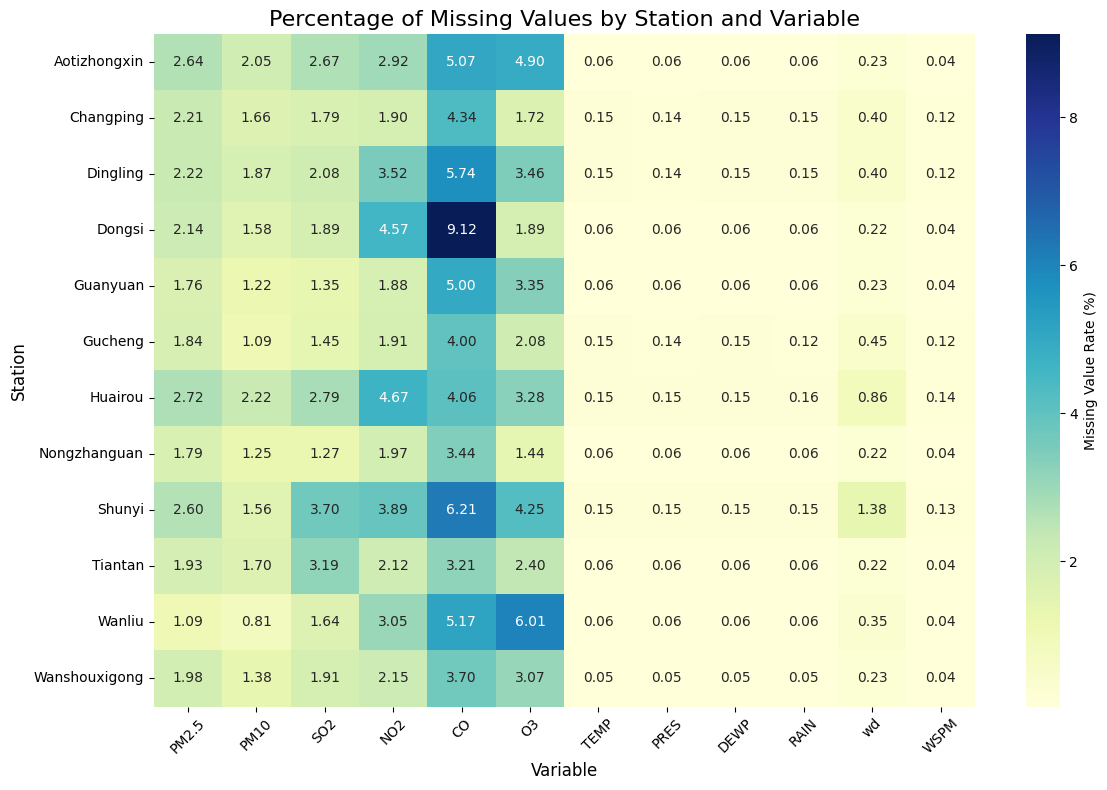

In [11]:
plt.figure(figsize=(12, 8))
sns.heatmap(nan_rates_by_station, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Missing Value Rate (%)'})
plt.title('Percentage of Missing Values by Station and Variable', fontsize=16)
plt.ylabel('Station', fontsize=12)
plt.xlabel('Variable', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Select the columns of interest
pollutant_cols = ['PM2.5', 'PM10',	'SO2', 'NO2', 'CO', 'O3','TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

# Group by station and calculate the mean for the selected columns
average_pollutants_by_station = df.groupby('station')[pollutant_cols].mean()

display(average_pollutants_by_station)

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
station,,,,,,,,,,,
Aotizhongxin,82.773611,110.060391,17.375901,59.305833,1262.945145,56.353358,13.584607,1011.846920,3.123062,0.067421,1.708496
Changping,71.099743,94.657871,14.958906,44.182086,1152.301345,57.940003,13.686111,1007.760278,1.505495,0.060366,1.853836
Dingling,65.989497,83.739723,11.749650,27.585467,904.896073,68.548371,13.686111,1007.760278,1.505495,0.060366,1.853836
Dongsi,86.194297,110.336742,18.531107,53.699443,1330.069131,57.210637,13.671490,1012.547419,2.447535,0.064020,1.860785
Guanyuan,82.933372,109.023303,17.590941,57.901643,1271.294377,55.795044,13.584607,1011.846920,3.123062,0.067421,1.708496
Gucheng,83.852089,118.861978,15.366162,55.871075,1323.974423,57.694879,13.864524,1008.829592,2.610442,0.064453,1.343310
Huairou,69.626367,91.482690,12.121553,32.497250,1022.554545,59.824713,12.445426,1007.598568,2.238619,0.067940,1.652021
Nongzhanguan,84.838483,108.991096,18.689242,58.097172,1324.350198,58.534682,13.671490,1012.547419,2.447535,0.064020,1.860785
Shunyi,79.491602,98.737026,13.572039,43.908865,1187.063979,55.201321,13.387969,1013.061938,2.465036,0.061094,1.807533


In [13]:
df[['PM2.5', 'PM10',	'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM'] ].describe()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,412029.000000,414319.000000,411747.000000,408652.000000,400067.000000,407491.000000,420370.000000,420375.000000,420365.000000,420378.000000,420450.000000
mean,79.793428,104.602618,15.830835,50.638586,1230.766454,57.372271,13.538976,1010.746982,2.490822,0.064476,1.729711
std,80.822391,91.772426,21.650603,35.127912,1160.182716,56.661607,11.436139,10.474055,13.793847,0.821004,1.246386
min,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000
25%,20.000000,36.000000,3.000000,23.000000,500.000000,11.000000,3.100000,1002.300000,-8.900000,0.000000,0.900000
50%,55.000000,82.000000,7.000000,43.000000,900.000000,45.000000,14.500000,1010.400000,3.100000,0.000000,1.400000
75%,111.000000,145.000000,20.000000,71.000000,1500.000000,82.000000,23.300000,1019.000000,15.100000,0.000000,2.200000
max,999.000000,999.000000,500.000000,290.000000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000


In [14]:
columns = ['PM2.5', 'PM10',	'SO2', 'NO2', 'CO', 'O3','TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
stations = df['station'].unique()
years = df['year'].unique()

Generating plots... 📊


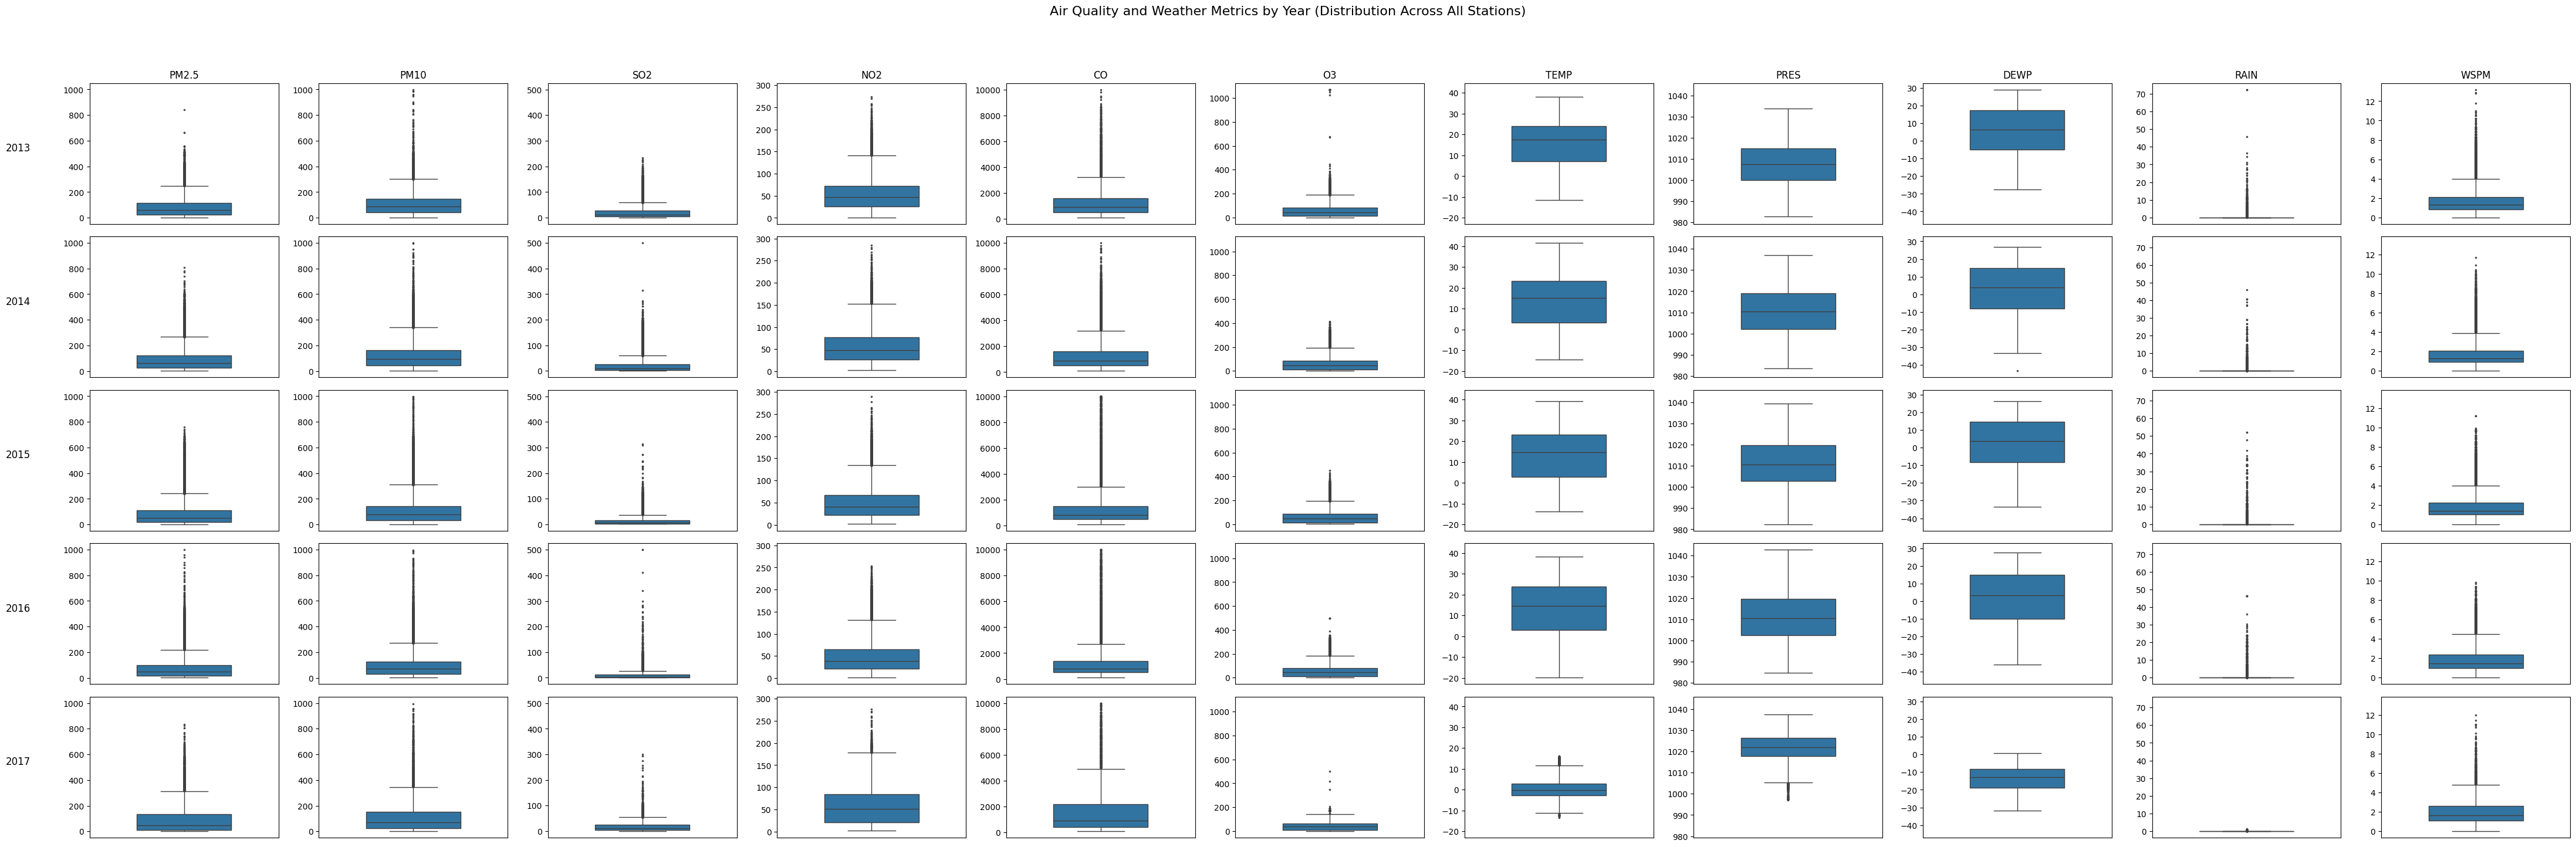

In [16]:
#  Create the Subplot Grid

fig, axes = plt.subplots(nrows=len(years),
                    ncols=len(columns),
                    figsize=(4 * len(columns), 3 * len(years)),
                    sharey='col',
                    squeeze=False)

print("Generating plots... 📊")

#  Loop Through Years and Columns to Plot Data
for i, year in enumerate(years):
    df_year = df[df['year'] == year]
    df_year = df_year.reset_index(drop=True)

    for j, column in enumerate(columns):
        ax = axes[i, j]
        sns.boxplot(data=df_year, y=column, ax=ax, fliersize=1.5, width=0.5)

        if i == 0:
            ax.set_title(column, fontsize=12)

        if j == 0:
            ax.set_ylabel(year, rotation=0, size='large', labelpad=40, ha='right')
        else:
            ax.set_ylabel('') # Hide y-label for other plots in the row

        ax.set_xlabel('')
        ax.set_xticks([])

# Display
fig.suptitle('Air Quality and Weather Metrics by Year (Distribution Across All Stations)', fontsize=16, y=0.99)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Generating plots... 📊


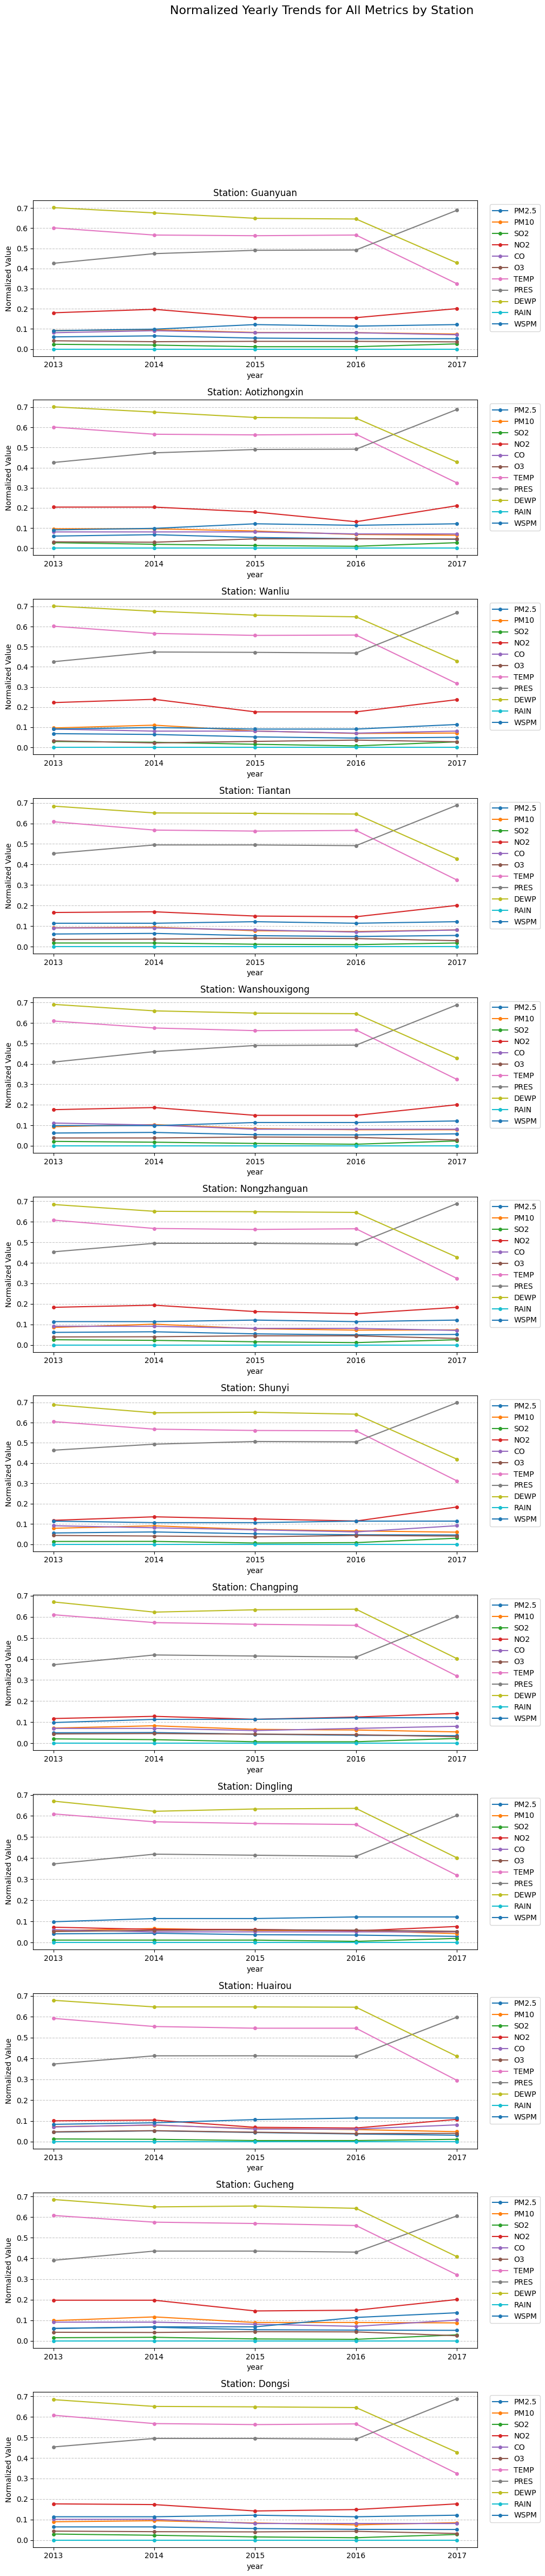

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_scaled = df.copy()
df_scaled[columns] = scaler.fit_transform(df[columns])

fig, axes = plt.subplots(
    nrows=len(stations),
    ncols=1,
    figsize=(12, len(stations) * 4), # Adjust size based on number of stations
    sharex=False # set the x-axis label and ticks for every subplot inside the loop, not just for the last one
)

if len(stations) == 1:
    axes = [axes]

fig.suptitle('Normalized Yearly Trends for All Metrics by Station', fontsize=16, y=1.02)
print("Generating plots... 📊")
# Loop Through Stations and Plot All Columns
for i, station in enumerate(stations):
    ax = axes[i]

    df_plot = df_scaled[df_scaled['station'] == station]

    yearly_median = df_plot.groupby('year')[columns].median()

    yearly_median.plot(ax=ax, style='-o', ms=4)

    # --- Formatting ---
    ax.set_title(f'Station: {station}')
    ax.set_ylabel('Normalized Value')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

    ax.set_xticks(years)
    ax.tick_params(axis='x', labelbottom=True) #This forces the x-axis tick labels (the years) to be visible for each individual subplot.

# Display
plt.tight_layout(rect=[0, 0.03, 0.85, 0.96]) # Increased bottom padding
plt.show()

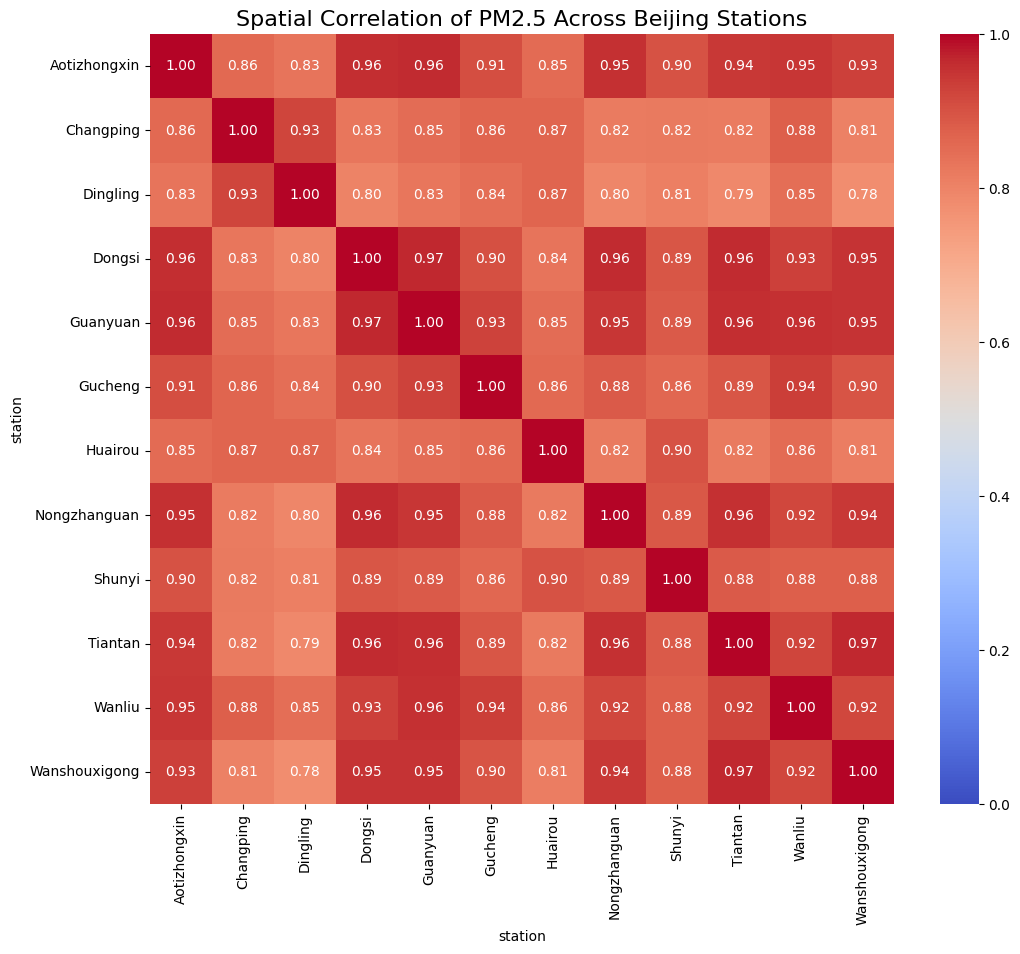

In [18]:
# Create the pivot table using the existing time columns
pm25_pivot = df.pivot_table(index=['year', 'month', 'day', 'hour'], columns='station', values='PM2.5')

station_corr = pm25_pivot.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(station_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1)
plt.title('Spatial Correlation of PM2.5 Across Beijing Stations', fontsize=16)
plt.show()

Here's how this data needs to be filed missing values:

**Overall Confirmation:** Even when broken down by station, the vast majority of missing values are still very low (most are under 1%). This means that for nearly all station-column combinations, the missing data consists of very small, isolated gaps.

**Where Interpolation is Safest:** For columns like TEMP, PRES, DEWP, RAIN, and WSPM, the missing percentages are consistently well under 1% across all stations. For these, linear or spline interpolation is an extremely safe and reliable choice. It will not introduce any significant bias into your dataset.

**Addressing the Higher Percentages:** You've identified a few specific cases where the missing percentage is a bit higher (e.g., CO and O3 at Aotizhongxin are around 5%). While this is higher than the average, it is considered a manageable amount for imputation. For these cases:

It would be a good practice to visualize the filled data for these specific station-column combinations to ensure the imputed values look reasonable and do not skew any key patterns.

In short, the overall strategy of using interpolation (linear or spline, depending on the variable's characteristics) is the best approach. The very low percentages confirm that this method is not only appropriate but highly effective for your dataset.

Wind Direction is a categorical column and needs to be handled differently than numerical data. The best approach is a two-step process:

**Handle Missing Values:** Since interpolation doesn't apply to categories, a good method is to fill the missing values with the most frequent wind direction (the mode).

**Encode the Column:** Machine learning models require numerical input. The best method for wind direction is One-Hot Encoding, which creates a new binary column for each unique direction. This avoids introducing a false sense of order that Label Encoding would (e.g., 'N' is not 'less than' 'SSW').